In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# # Add the work folder shared with you into your My Drive by adding it as a shortcut before running this cell
# %cd gdrive/MyDrive/work

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.signal import correlate
import copy


# Gold Code Generator

This code takes in a satellite ID and returns its goldcode.

Reference: https://natronics.github.io/blag/2014/gps-prn/

In [2]:
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

def shift(register, feedback, output):
    """GPS Shift Register

    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:

    """

    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]

    fb = sum([register[i-1] for i in feedback]) % 2

    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]

    register[0] = fb

    return out

def PRN(sv):

    """Build the CA code (PRN) for a given satellite ID

    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite

    """

    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here

    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table

        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca

# Fine Doppler

In [ ]:
import numpy as np

def apply_doppler_shift(compdata, fd, fs, doppler_shift, st):
    n = np.arange(len(compdata)) + st
    shift_factor = np.exp(-1j * 2 * np.pi * (fd + doppler_shift) * n / fs)
    return compdata * shift_factor

def correlate(compdata, chunk):
    correlation = fftconvolve(compdata,chunk[::-1], mode='valid')
    # plt.plot(np.imag(correlation))
    # plt.show()
    return correlation

def search_doppler_shift(compdata, st, chunk, fd, fs, search_param = [-10, 1, 10], imag_threshold=300000):
    best_shift = 0
    max_correlation = 0
    prev_min = 1e7
    curr_min = 1e7
    best_corr = None
    for doppler_shift in [search_param[0]+search_param[1]*i for i in range(int((search_param[2]-search_param[0])/search_param[1]))]:
        shifted_data = apply_doppler_shift(compdata, fd, fs, doppler_shift, st)
        corr = correlate(shifted_data, chunk)
        real_corr = np.real(corr)
        imag_corr = np.imag(corr)
        
        if np.all(np.abs(imag_corr) < imag_threshold):
            # print(imag_corr[:20])
            curr_min = np.mean(np.abs(imag_corr)) #Finding max in imag_corr and checking if it is less than prev max
            if (curr_min < prev_min):
                prev_min = curr_min
                best_shift = doppler_shift
                best_corr = copy.deepcopy(corr)
    if (best_corr is None):
        print("No valid correlation found")
        return best_shift, max_correlation
    plt.figure(figsize=(10, 6))
    plt.plot(np.real(best_corr), label='Real Part', color='blue')
    plt.plot(np.imag(best_corr), label='Imaginary Part', color='red')
    plt.title(f'Fine Doppler Correction: {best_shift}')
    plt.xlabel('Sample Index')
    plt.ylabel('Correlation Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_shift, max_correlation



# Inverse GPS Signal Generator

This block of code loads the output tracking data generated by gnss-sdr and takes the I value from it and multiplies it with the gold code of that satellite, upsamples it and returns it.

NOTE!!!!
In this piece of code, we have multiplied the doppler shift with the upsampled PRN code. This is wrong as we are not taking into consideration about the phases of the actual samples which will be different. when correlating with the complex data, at some point far away the doppler would be 2pif_d *t/f_s wherease the prncode will have some different t, therefor giving wrong results as can be seen in the curve


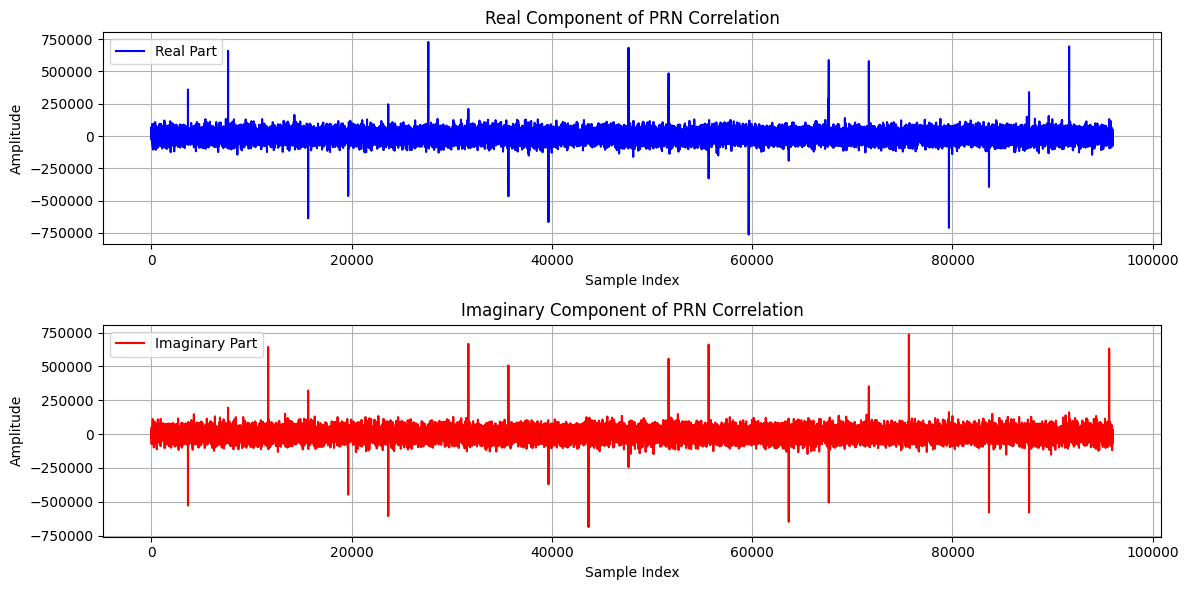

In [9]:
filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'
data = np.fromfile(filepath,dtype = np.short)
compdata = data[::2] + (1j)*data[1::2]
sv = 15
prn = PRN(sv)
prn = [-1 if x == 0 else x for x in prn]

prn_upsample = []
n = 0
for i in range(4000):
    if ((i+1)/4000 <= (n+1)/1023):
        prn_upsample.append(prn[n])
    else:
        n = n+1
        prn_upsample.append(prn[n])
# Doppler Shift
doppler = {18 : 0, 12: 2697.905, 13: -2848.802, 10: 2891.328, 5: -2449.682, 15: -1816.517, 23: 2137.817}
f_d = doppler[sv]

n = np.arange(len(prn_upsample))
prn_upsample = np.multiply(np.array(prn_upsample),np.exp(1j*2*np.pi*f_d*n/4000000))
# shift_data = apply_doppler_shift(compdata, f_d, 4000000, 0, 0)

# Correlate the PRN code with the data
prn_correlated = np.correlate(compdata[:100000],prn_upsample)
indices = np.where(np.abs(prn_correlated) > 200000)[0]
plt.figure(figsize=(12, 6))

# Plot real part
plt.subplot(2, 1, 1)
plt.plot(np.real(prn_correlated), label='Real Part', color='blue')
plt.title('Real Component of PRN Correlation')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot imaginary part
plt.subplot(2, 1, 2)
plt.plot(np.imag(prn_correlated), label='Imaginary Part', color='red')
plt.title('Imaginary Component of PRN Correlation')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Here we have rectified the earlier mistake, we have multiplied the doppler with the corresponding complex data.

In [9]:
filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'
# filepath = '/home/joel/gps-sdr-sim-master/Gen_Motion_data/split_v3_1_50/xab'
# filepath = '/home/joel/gps-sdr-sim-master/Gen_Motion_data/split_path1_150/xad'
# filepath = '/home/joel/gps-sdr-sim-master/Gen_Motion_data/split_path1/xad'
# filepath = '/home/joel/data/split/mydataa'
# filepath = '/home/joel/gain64/split/mydataa'
data = np.fromfile(filepath,dtype = np.short)
compdata = data[::2] + (1j)*data[1::2]
sv = 10


prn = PRN(sv)
prn = [-1 if x == 0 else x for x in prn]

prn_upsample = []
n = 0
for i in range(4000):
    if ((i+1)/4000 <= (n+1)/1023):
        prn_upsample.append(prn[n])
    else:
        n = n+1
        prn_upsample.append(prn[n])

# Doppler Shift
doppler = {18 : 0, 12: 2697.905, 13: -2848.802, 10: 2891.328, 5: -2449.682, 15: -1816.517, 23: 2137.817}
# -798.336
# f_d = doppler[sv]
f_d1 = 2891.328
n = np.arange(len(compdata[:7000000]))
# prn_upsample = np.multiply(np.array(prn_upsample),np.exp(1j*2*np.pi*f_d*n/4000000))


In [10]:
print(len(compdata))

199933333


24000000


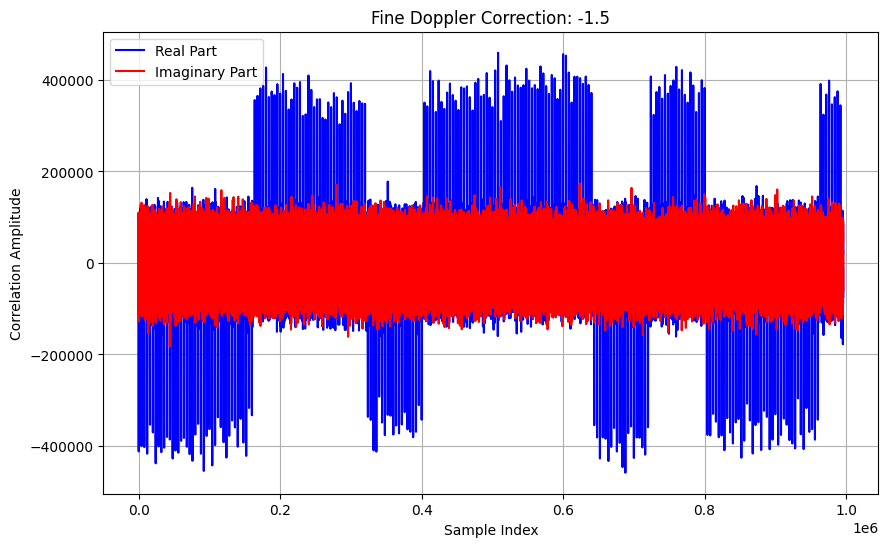

-1.5


In [11]:
# st = 70000000
st1 = 299900000*0
st = int(24000000*1)
print(st)
compdata1 = copy.deepcopy(compdata[st:st+1000000])
corrected_shift, _ = search_doppler_shift(compdata1, st1+st, prn_upsample, f_d1, 4000000, [-5,0.1,0])
print(corrected_shift)
# corrected_shift, _ = search_doppler_shift_2(compdata1, st, prn_upsample, f_d1, 4000000, [-10,0.01,10])
# print(corrected_shift, _)

[    99    100    101   4099   4100   4101   8100   8101  12100  12101
  16100  20100  24099  24100  24101  28100  28101  32099  32100  32101
  36099  36100  40100  44100  44101  48099  48100  48101  52100  52101
  56099  56100  56101  60100  64100  68099  68100  68101  72099  72100
  72101  76099  76100  76101  80100  84100  88099  88100  88101  92099
  92100  92101  96099  96100 100100 104099 104100 104101 108099 108100
 112100 116100 120099 120100 124099 124100 124101 128100 132100 136100
 140099 140100 144100 148099 148100 152099 152100 152101 156100 160100
 164100 168099 168100 172099 172100 176099 176100 180099 180100 180101
 184100 188099 188100 192099 192100 196099 196100 200099 200100 204099
 204100 204101 208099 208100 212099 212100 216099 216100 220099 220100
 220101 224099 224100 228099 228100 232100 236100 240099 240100 240101
 244099 244100 248099 248100 252099 252100 256099 256100 260099 260100
 264099 264100 268099 268100 272099 272100 276099 276100 280099 280100
 28410

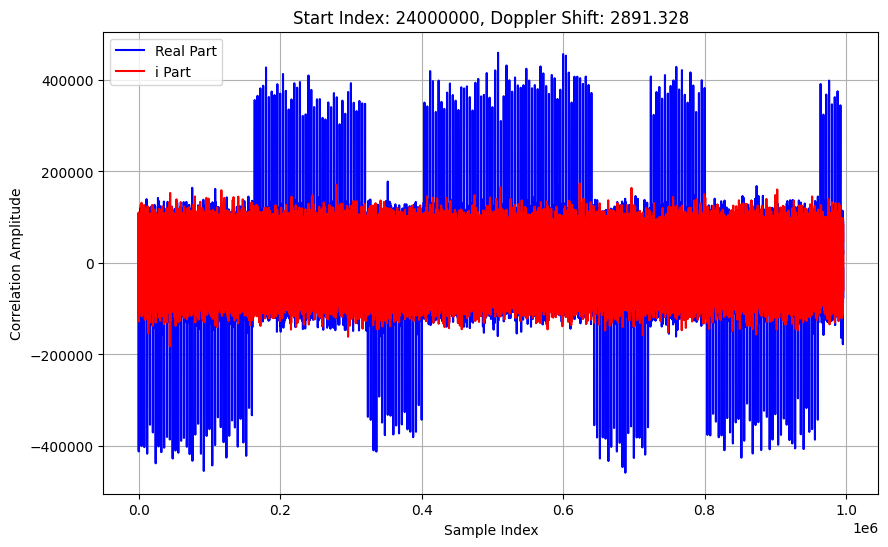

In [13]:
# corrected_shift = 0
# f_d1 = -915.515
# f_d1 = -955.776
shifted_data = apply_doppler_shift(compdata1, f_d1, 4000000, corrected_shift, st + st1)
corr = correlate(shifted_data[:], prn_upsample)
print((np.where(abs(np.real(corr)) > 300000)[0]))

plt.figure(figsize=(10, 6))
plt.plot(np.real(corr), label='Real Part', color='blue')
plt.plot(np.imag(corr), label='i Part', color='red')
plt.title(f'Start Index: {st + st1}, Doppler Shift: {f_d1}')
plt.xlabel('Sample Index')
plt.ylabel('Correlation Amplitude')
plt.legend()
plt.grid(True)
plt.show()

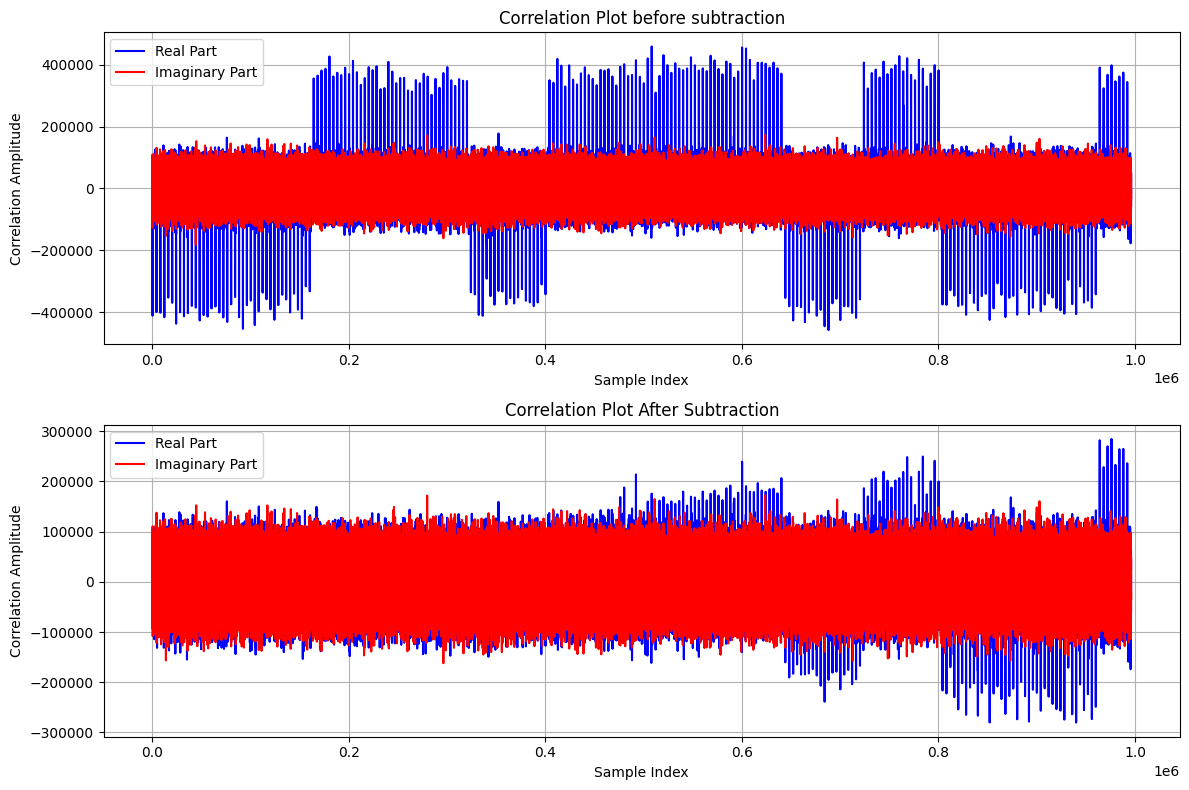

In [16]:
prn_upsample = np.array(prn_upsample)
shifted_data1 = apply_doppler_shift(compdata1, f_d1 + corrected_shift, 4000000, 0, st)
corr_before = correlate(shifted_data1, prn_upsample)

for i in range(100, 1000000-4000,4000):
    alph = np.dot(prn_upsample.T, shifted_data1[i:i+4000])/np.dot(prn_upsample.T, prn_upsample)
    # print(alph)
    shifted_data1[i:i+4000] = shifted_data1[i:i+4000] - alph*prn_upsample

for i in range(145, 1000000-4000,4000):
    alph = np.dot(prn_upsample.T, shifted_data1[i:i+4000])/np.dot(prn_upsample.T, prn_upsample)
    # print(alph)
    shifted_data1[i:i+4000] = shifted_data1[i:i+4000] - alph*prn_upsample

for i in range(143, 1000000-4000,4000):
    alph = np.dot(prn_upsample.T, shifted_data1[i:i+4000])/np.dot(prn_upsample.T, prn_upsample)
    # print(alph)
    shifted_data1[i:i+4000] = shifted_data1[i:i+4000] - alph*prn_upsample


# shifted_data1 = apply_doppler_shift(compdata1, - corrected_shift, 4000000, 0, st)
corr_new = correlate(shifted_data1, prn_upsample)


plt.figure(figsize=(12, 8))

# Plot corr_before
plt.subplot(2, 1, 1)
plt.plot(np.real(corr_before), label='Real Part', color='blue')
plt.plot(np.imag(corr_before), label='Imaginary Part', color='red')
plt.title('Correlation Plot before subtraction')
plt.xlabel('Sample Index')
plt.ylabel('Correlation Amplitude')
plt.legend()
plt.grid(True)

# Plot corr_new
plt.subplot(2, 1, 2)
plt.plot(np.real(corr_new), label='Real Part', color='blue')
plt.plot(np.imag(corr_new), label='Imaginary Part', color='red')
plt.title('Correlation Plot After Subtraction')
plt.xlabel('Sample Index')
plt.ylabel('Correlation Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Correlate the PRN code with the data
# prn_correlated1 = np.correlate(compdata_shifted1,prn_upsample)
prn_correlated2 = fftconvolve(compdata_shifted2,prn_upsample[::-1], mode='valid')
# prn_correlated3 = fftconvolve(compdata_shifted3,prn_upsample[::-1], mode='valid')


# indices = np.where(np.abs(prn_correlated) > 200000)[0]
# print(indices)
# plt.plot(np.real(prn_correlated1))
# plt.plot(np.imag(prn_correlated1))
# plt.show()
# plt.plot(np.abs(prn_correlated1))
# plt.show()

plt.plot(np.real(prn_correlated2))
plt.plot(np.imag(prn_correlated2))
plt.show()
# plt.plot(np.abs(prn_correlated2))
# # plt.show()

# plt.plot(np.real(prn_correlated3))
# plt.plot(np.imag(prn_correlated3))
# plt.show()
# # plt.plot(np.abs(prn_correlated3)[:100000])
# plt.show()


# Random String correlation

In [ ]:
l = [1,-1]
random_string = []
for i in range(6):
  random_string.append(np.random.choice(l))

In [ ]:
random_code = []
for i in range(len(random_string)):
  random_code.append(np.multiply(random_string[i],prn_upsample))
random_code = np.array(random_code).flatten()

In [ ]:
len(random_code)

In [ ]:
n = np.arange(len(compdata[:100000]))
# prn_upsample = np.multiply(np.array(prn_upsample),np.exp(1j*2*np.pi*f_d*n/4000000))
compdata_shifted = np.multiply(compdata[:100000],np.exp(-1j*2*np.pi*f_d*n/4000000))
# Correlate the PRN code with the data
prn_correlated_1 = np.correlate(compdata_shifted,random_code)[:25000]
indices = np.where(np.abs(prn_correlated) > 500000)[0]
print(indices)
plt.plot(np.real(prn_correlated_1))
plt.show()
plt.plot(np.imag(prn_correlated_1))
plt.show()
plt.plot(np.abs(prn_correlated_1))
plt.show()

In [ ]:
subsetarr = []
for i in range(2400,2600):
  subsetarr.append(np.abs(prn_correlated[i]))

In [ ]:
# plt.plot(subsetarr,marker='o')

# Subtraction of satellite 18 data

In [ ]:
def process(data):
    print(data.nbytes / (1024**3))
import numpy as np
element_size = np.dtype(np.short).itemsize
chunk_size = 1024**2 * 800 # Read 1GB chunks (adjust as needed)
filepath = '/home/joel/data/gpssim.dat'
with open(filepath, "rb") as file:
    file.seek(0, 2)  # Move the cursor to the end of the file
    filesize = file.tell()  # Get the current position of cursor, which is the size of the file
    file.seek(0)  # Move the cursor back to the start of the file
    chunk_size = filesize // 8  # Set chunk size to half of the file size
    while chunk := file.read(chunk_size):
        data = np.frombuffer(chunk, dtype=np.short)
        process(data)  # Process the data
        for i in range(100000000):
            pass


In [4]:
# 10001011
# filepath = '/home/joel/data/gpssim.dat'
# filepath = '/home/joel/data/split/mydataa'
filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'

data = np.fromfile(filepath, dtype=np.short)
compdata = data[::2] + (1j) * data[1::2]

# Calculate the size taken up by them in the memory
data_size_gb = data.nbytes / (1024 ** 3)
compdata_size_gb = compdata.nbytes / (1024 ** 3)

print(f"Size of data in memory: {data_size_gb:.2f} GB")
print(f"Size of compdata in memory: {compdata_size_gb:.2f} GB")
sv = 10
prn = PRN(sv)
prn = [-1 if x == 0 else x for x in prn]

prn_upsample = []
n = 0
for i in range(4000):
    if ((i+1)/4000 <= (n+1)/1023):
        prn_upsample.append(prn[n])
    else:
        n = n+1
        prn_upsample.append(prn[n])
# Doppler Shift
doppler = {18 : 0, 12: 2697.905, 13: -2848.802, 10: 2891.328, 5: -2449.682, 15: -1816.517, 23: 2137.817}

Size of data in memory: 0.74 GB
Size of compdata in memory: 2.98 GB


In [5]:
gold_code = []
for i in range(20):
  gold_code.append(prn_upsample)
gold_code = np.array(gold_code).flatten()

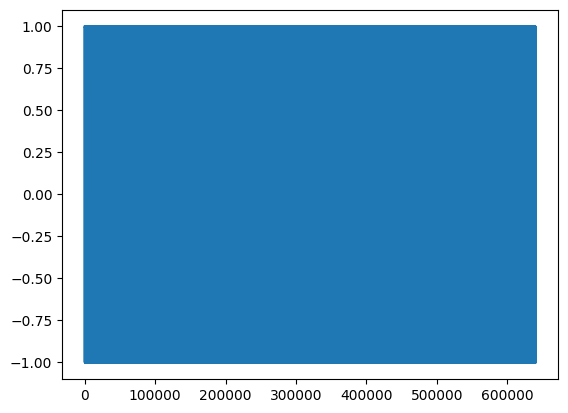

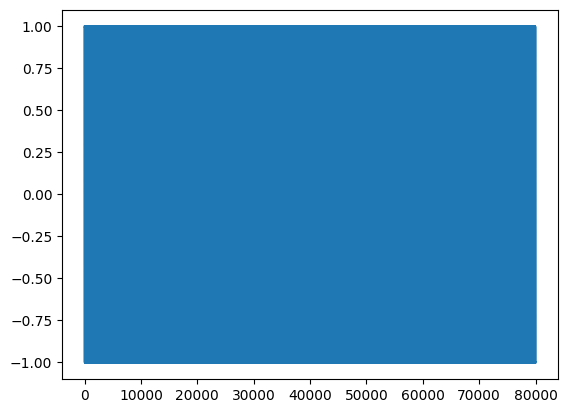

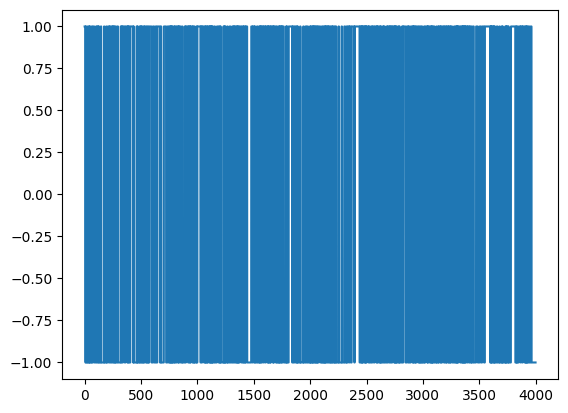

In [ ]:
code = [1,0,0,0,1,0,1,1]
v1 = []
for i in range(len(code)):
  if code[i] == 1:
    v1.append(np.array(gold_code))
  else:
    v1.append(np.multiply(-1, np.array(gold_code)))
v1 = np.array(v1).flatten()
plt.plot(v1)
plt.show()
plt.plot(gold_code)
plt.show()
plt.plot(prn_upsample)
plt.show()

In [7]:
f_d = doppler[sv]
n = np.arange(len(compdata))
compdata_shifted = np.round(np.multiply(compdata,np.exp(-1j*2*np.pi*f_d*n/4000000)), decimals=5)

# Correlate the PRN code with the data



In [8]:
del data
del n
del compdata
# del compdata_gpu

In [9]:
# data_correlated = fftconvolve(compdata_shifted[len(compdata_shifted)//2:],v1[::-1], mode='valid')

In [18]:
from scipy.signal import fftconvolve
import numpy as np

def chunked_fftconvolve(data, v1, chunk_size=10**7):
    result = np.zeros(len(data) - len(v1) + 1, dtype=np.complex128)
    
    for i in range(0, len(data) - len(v1) + 1, chunk_size):
        end = min(i + chunk_size + len(v1) - 1, len(data))
        chunk = data[i:end]
        # Perform FFT-based convolution on the chunk
        chunk_result = correlate(chunk, v1, mode='valid')
        result[i:i + len(chunk_result)] = chunk_result
        
    return result

compdata_shifted_half = compdata_shifted[:len(compdata_shifted)]
data_correlated_1 = chunked_fftconvolve(compdata_shifted_half, v1)


In [11]:
del compdata_shifted_half
# del compdata_shifted

In [ ]:
# print(indices)
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

axs[0].plot(np.abs(data_correlated_1)[:100000000], label='Abs Part (First Half)', color='blue')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Abs Part of Data Correlation (First Half)')
axs[0].legend()
axs[0].grid(True)

# axs[1].plot(np.abs(data_correlated_1)[100000000:], label='Abs Part (Second Half)', color='green')
# axs[1].set_xlabel('Sample Index')
# axs[1].set_ylabel('Amplitude')
# axs[1].set_title('Abs Part of Data Correlation (Second Half)')
# axs[1].legend()
# axs[1].grid(True)

# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(np.imag(data_correlated_1)[:100000000], label='Imaginary Part (First Half)', color='red')
# plt.plot(np.imag(data_correlated_1)[100000000:], label='Imaginary Part (Second Half)', color='orange')
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.title('Imaginary Part of Data Correlation')
# plt.legend()
# plt.grid(True)
# plt.show()
# plt.plot(np.abs(data_correlated_?1)[0:43000000])?
# plt.plot(indices, np.abs(data_correlated)[indices])
# plt.plot(np.imag(data_correlated))
# plt.show()

In [ ]:
plt.plot(np.abs(data_correlated_1)[100000000:])
plt.show()

In [ ]:
plt.plot(np.imag(data_correlated))

In [ ]:
indices = np.where(np.abs(data_correlated_1) > 60000000)[0]
print(indices)

In [ ]:
# print(indices[:100])
# print()
print(max(np.abs(data_correlated_1[:1000000])))
print(max(np.abs(data_correlated_1[20000000:30000000])))
print(max(np.abs(data_correlated_1[40000000:50000000])))
print(max(np.abs(data_correlated_1[65000000:75000000])))

index_1 = np.where(np.abs(data_correlated_1) == max(np.abs(data_correlated_1[:1000000])))[0]
index_2 = np.where(np.abs(data_correlated_1) == max(np.abs(data_correlated_1[20000000:30000000])))[0]
index_3 = np.where(np.abs(data_correlated_1) == max(np.abs(data_correlated_1[40000000:50000000])))[0]
index_4 = np.where(np.abs(data_correlated_1) == max(np.abs(data_correlated_1[65000000:80000000])))[0]

print(index_1)
print(index_2)
print(index_3)
print(index_4)

print(max(np.abs(data_correlated_1)))



# print(len(compdata))

In [41]:
# Select index: 3200 satellite 23
# y = compdata_shifted[index_4[0]: index_4[0] + 640000]
st = 72324011
y = compdata_shifted[st:st+640000]
x = v1
# print(y)
alp_est = np.dot(x.T, y)/np.dot(x.T,x)
print(alp_est)
# we know alpha = dot(y1,v1)/2norm(v1) - summation(dot(vi,v1)/2norm(v1))
# v1norm = LA.norm(v1)
# alpha = np.dot(compdata_shifted,v1)/v1norm
# print(alpha)
# print(x.dtype)
# print(y.dtype)
# print(np.dot(x.T,x))
#94.96 + 8j for og data
# 48.33 + 3.81j for 0.5*data



(-40.19530559471874-81.33175421501562j)


Now we will subtract using the estimated alpha value

In [46]:
# corr1 = fftconvolve(compdata_shifted[:1000000],x[::-1],mode='valid')
# print(corr1)
# plt.plot(corr1)
# plt.show()
compdata_copy = copy.deepcopy(compdata_shifted[st:st+1000000])
compdata_copy[:640000] = compdata_copy[:640000] - alp_est*x
# yhat = compdata_copy - alp_est*x
corr2 = np.correlate(compdata_copy[:640002], x)
print(corr2)
corr3 = correlate(compdata_copy[:640002], x, mode='valid', method='fft')
print(corr3)
corr4 = fftconvolve(compdata_copy[:640000], x[::-1], mode='valid')
print(corr4)
# plt.plot(corr2)
# plt.show()

[-3.72529030e-09-9.31322575e-10j  2.98880543e+05-2.30621852e+06j
  7.94556432e+05-1.02492245e+06j]
[-6.91055394e-09-2.00056069e-09j  2.98880543e+05-2.30621852e+06j
  7.94556432e+05-1.02492245e+06j]
[-7.91549683e-09-1.8119812e-09j]


[ 703.       +6.j        78.0219   +4.6457j   230.01776  +0.91073j ...
 -137.40332 +11.54677j -288.44987  +6.45532j -397.95256+346.08924j]


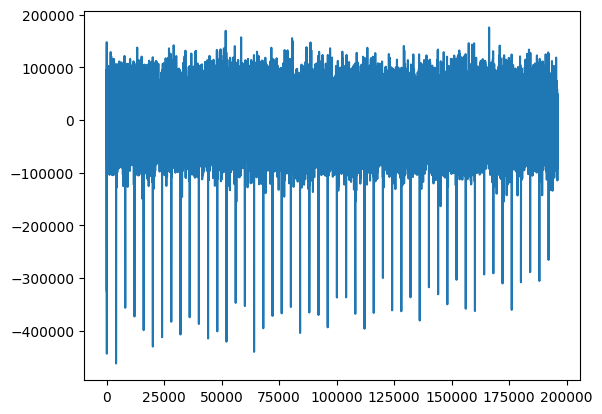

In [15]:
y1 = np.array(compdata_shifted[:200000])
t= alp_est*np.array(prn_upsample)
print(y1[4000*0: 4000])
t_repeated = np.tile(t,50)
y1 = y1 - t_repeated
cor = np.correlate(y1,prn_upsample)
plt.plot(np.real(cor))

In [ ]:
import numpy as np
filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/output_upd.dat'
data1 = np.fromfile(filepath,dtype = np.short)
compdata1 = data1[::2] + (1j)*data1[1::2]
print(compdata1[25323923])

filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'
data = np.fromfile(filepath,dtype = np.short)
compdata2 = data[::2] + (1j)*data[1::2]
print(compdata2[120323923])

print(np.array_equal(compdata1,compdata2))

# for i in range(640000):
#   if compdata1[3200+i] != compdata2[3200+i]:
#     print(compdata1[3200+i],compdata2[3200+i])

In [ ]:
filepath = '/home/joel/gps-sdr-sim-master/gen_data_split/mydataa'
f = open(filepath, "rb")
f.seek(-2,2)
data = f.readlines()
print(data)

# filepath2 = '/home/joel/gps-sdr-sim-master/gen_data_split/output_upd.dat'
# f2 = open(filepath2, "rb+")
# # f2.seek(0,2)
# # b1 = bytearray(b'_')
# # f2.write(b1)
# f2.seek(-2,2)
# # print()

# data2 = f2.readlines()
# print(data2)